In [28]:
import tensorflow as tf
import tensorflowjs as tfjs
from maml import MAML
from model import Model
from tasks import SinusoidRegressionTaskDistribution
from reptile import Reptile
import numpy as np
import matplotlib.pyplot as plt


#is gpu available?
print("GPU Available: ", tf.test.is_gpu_available())

GPU Available:  True


I0000 00:00:1734293618.996355  100362 gpu_device.cc:2022] Created device /device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [29]:
import tensorflow as tf
import json
import numpy as np

# Paths to files
json_file_path = '/home/kristmro/workspace/MetaLearningCodes/TestingSin/models/reptile-reproduce.h5/model.json'
weights_file_path = '/home/kristmro/workspace/MetaLearningCodes/TestingSin/models/reptile-reproduce.h5/group1-shard1of1.bin'

# Load the JSON file
with open(json_file_path, 'r') as file:
    model_data = json.load(file)

# Extract the model topology and weights manifest
model_config = model_data['modelTopology']['model_config']
weights_manifest = model_data['weightsManifest'][0]['weights']

# Reconstruct the model architecture
model = tf.keras.Sequential.from_config(model_config['config'])

# Load weights from the binary file
with open(weights_file_path, 'rb') as weight_file:
    binary_weights = weight_file.read()

# Decode weights based on manifest
weights = []
offset = 0
for weight_info in weights_manifest:
    # Get the shape and size of each weight tensor
    shape = weight_info['shape']
    dtype = weight_info['dtype']
    dtype = np.float32 if dtype == 'float32' else np.float64
    size = np.prod(shape)

    # Extract and reshape the binary data for this weight
    weight_data = np.frombuffer(binary_weights, dtype=dtype, count=size, offset=offset)
    weights.append(weight_data.reshape(shape))
    offset += size * np.dtype(dtype).itemsize

# Set the weights into the model
model.set_weights(weights)

# Save the model in SavedModel format
output_path = '/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/reptile-reproduce.keras'
model.save(output_path)
print(f"Model successfully saved to {output_path}")



Model successfully saved to /home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/reptile-reproduce.keras


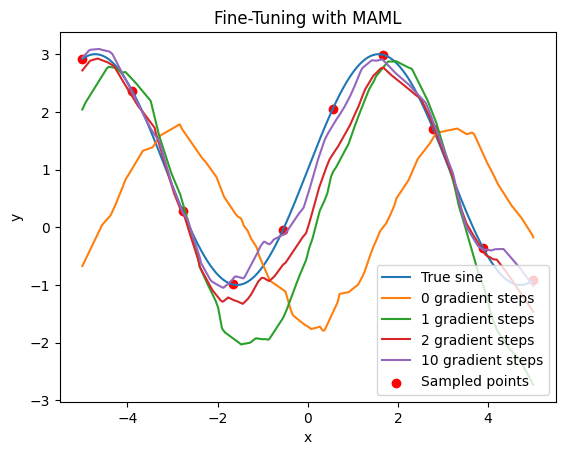

In [ ]:

# Define the task (sinusoidal function)
def task(x):
    return 2 * tf.sin(x)+1

# Generate training data points (xs, ys)
xs = tf.reshape(tf.linspace(-5., 5., 10), (10, 1))  # 10 sample points
ys = task(xs)

# Generate points for the true sine function
x = tf.reshape(tf.linspace(-5., 5., 1000), (1000, 1))  # 1000 points for plotting
plt.plot(x, task(x), label="True sine")

# Assume the MAML model is loaded
# Replace `maml_model` with your actual loaded MAML model variable
# Example: maml_model = tf.keras.models.load_model('<your_saved_model_path>')
maml_model = tf.keras.models.load_model('/home/kristmro/workspace/MetaLearningCodes/TestingSin/savedModels/maml-reproduce.keras')

# Define a custom loss function (Mean Squared Error)
loss_fn = tf.keras.losses.MeanSquaredError()

# Fine-tuning loop
for n_steps in [0, 1, 2, 10]:
    # Initialize the model's trainable weights for fine-tuning
    updated_weights = maml_model.trainable_weights
    
    # Perform fine-tuning steps
    for step in range(n_steps):
        with tf.GradientTape() as tape:
            # Compute the loss on the current task
            predictions = maml_model(xs)
            loss = loss_fn(ys, predictions)
        
        # Compute gradients
        grads = tape.gradient(loss, maml_model.trainable_weights)
        
        # Apply gradients to update the weights
        for w, g in zip(updated_weights, grads):
            w.assign_sub(0.01 * g)  # Learning rate = 0.01

    # Make predictions with updated weights
    maml_model.set_weights(updated_weights)  # Apply updated weights
    predictions = maml_model(x)
    
    # Plot the predictions
    plt.plot(x, predictions, label=f"{n_steps} gradient steps")

# Plot the training points
plt.scatter(xs, ys, color='red', label='Sampled points')

# Finalize the plot
plt.title('Fine-Tuning with MAML')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [ ]:


def Plot(name, gradientSteps, nSamples, sampleLower, sampleUpper):
    taskDistribution = SinusoidRegressionTaskDistribution()

    modelPath = 'savedModels/' + name + '.kearas'

    metaModel = Model(modelPath, taskDistribution, innerLearningRate=0.01)

    task = taskDistribution.sampleTask()
    ys, xs = task.sampleFromTask(nSamples, sampleLower, sampleUpper)

    x = tf.reshape(tf.linspace(-5., 5., 1000), (1000, 1))

    # Nice when saving the figure
    plt.subplots(num='%s %s %d %d %d' % (name, str(gradientSteps), nSamples, sampleLower, sampleUpper))
    plt.plot(x, task(x), label="True sine")

    for nSteps in ([0] + gradientSteps if not 0 in gradientSteps else gradientSteps):
        prediction = metaModel.fit(ys, xs, nSteps)(x)
        print('Mean squared error from -5 to 5 with %d steps: %.4f' %
              (nSteps, metaModel.lossfn(task(x), prediction)))
        plt.plot(x, prediction, label='%d gradient steps' % nSteps)

    plt.scatter(xs, ys)
    plt.title('Comparing gradient steps for model ' + name)
    plt.ylim([-5, 5])
    plt.legend()
    plt.show()

